# Small Temporal Density Variations


The following code is used to visualise density varitions from photographs of a moving ridge in the lab. The code firstly takes a background photograph, finds the density profile then compares said profile to photographs taken of the moving ridge.

In [1]:
%matplotlib qt
#notebook backend important
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os.path
import cv2
from tkinter.filedialog import askopenfilename
from tkinter.filedialog import askopenfilenames
import matplotlib.animation as animation
from scipy import signal 
import cmocean as cmo

In [2]:
#A simple function used when clicking of photos to determine where in an array the click is
def index_find(depths,click):
    lst = depths<click
    for i,v in enumerate(lst):
        if v==True:
            return i

## Loading the data from the experiments 

In [3]:
excel_path = askopenfilename() #path to excel doc with data
data = pd.read_excel(excel_path)

In [4]:
%matplotlib qt

run_num = int(input('Run number:'))
print('Data read')
#getting data from excel doc
rho_bottom = data.iloc[run_num-1, 8]
rho_top = data.iloc[run_num-1, 7]
depth = data.iloc[run_num-1, 3]

tank_length=.38 #important for video


Run number:21
Data read


## Analysing the background image

In [5]:
#now choose background image, this image should not contain topography

background_path = askopenfilename() 
b_image = cv2.imread(background_path,0)

Now we choose the area of photograph we want to average over to create a background stratification profile. The top of the region should be the free surface and the bottom should be the base of the tank.

In [6]:
plt.figure()
plt.title('Choose Area to Average over')
plt.axis('off')
plt.imshow(b_image, cmap='gist_gray')
print('Select the top left then the bottom right' )
density_locations = plt.ginput(2)
print('Locations recorded')

zbot_0=int(np.round(density_locations[0][1]))
ztop_0=int(np.round(density_locations[1][1]))
xleft=int(np.round(density_locations[0][0]))
xright=int(np.round(density_locations[1][0]))

back_crop= b_image[zbot_0:ztop_0,xleft:xright]


#cropping and determining the background profile

log_back = np.log(back_crop)

#getting rid of unwated inf_values
log_back[np.isinf(log_back)]=np.nan

mean_ratio_profile = np.mean(log_back,1)
intensity = mean_ratio_profile
depth_array = -np.linspace(0,depth,len(mean_ratio_profile))

Select the top left then the bottom right
Locations recorded


### Fixing up the background absorbtion profile

The top and bottom of the profile need to be fixed up

In [9]:
# fixing up the top of the profile, making it have a constant value
splintensity=np.copy(intensity)

plt.figure()
plt.plot(intensity,depth_array)
plt.xlabel('ln (Ix/Ix0)')
plt.ylabel('z (m)')
plt.title('Select Top Section of Absorption Profile')
print('Choose bottom of top section')
topsection = plt.ginput(1)[0][1]
print('Location recorded')
ztop=index_find(depth_array,topsection) 
splintensity[:ztop]=splintensity[ztop]

Choose bottom of top section
Location recorded


In [82]:
#fixing up the bottom of the profile, giving it a linear function
#can skip this step if camera is not taking in the bottom of the tank


plt.figure()
plt.plot(splintensity,depth_array)
plt.xlabel('ln (Ix/Ix0)')
plt.ylabel('z (m)')
plt.title('Select Bottom Section of Absorption Profile')
print('Choose top then bottom')
bottomsection = plt.ginput(2)
print('Locations recorded')

#finding equation of line
slope = (bottomsection[0][1]-bottomsection[1][1])/(bottomsection[0][0]-bottomsection[1][0])

zbot=index_find(depth_array, bottomsection[0][1]) 

splintensity[zbot:]=slope*np.linspace(0,bottomsection[0][1], len(splintensity)-zbot)+splintensity[zbot]

Choose top then bottom
Locations recorded


In [10]:
#plot that shows the raw vs the 'fixed' absorbtion profile

plt.figure()
plt.title('Absorbtion Profile')
plt.xlabel('ln (Ix/Ix0)')
plt.ylabel('z (m)')
plt.plot(intensity,depth_array, 'b', label='Raw')
plt.plot(splintensity,depth_array, 'r',label='Updated')
plt.legend()

In [11]:
#determining the location of density samples top then bottom
plt.figure()
plt.title('Density Sample Locations')
plt.ylabel('z (m)')
plt.xlabel('x (m)')
plt.imshow(back_crop, cmap='gist_gray', extent=[0,tank_length,-depth,0])
print('Position of density sample close to top, then close to bottom' )
density_locations = plt.ginput(2)
print('Locations recorded')

zbot_rho=index_find(depth_array,density_locations[1][1])
ztop_rho=index_find(depth_array,density_locations[0][1])

beta = (rho_bottom-rho_top)/(splintensity[zbot_rho]-splintensity[ztop_rho])
splintensity_bottom_ref = splintensity[zbot_rho]

rho = rho_bottom+np.float64(beta*(splintensity-splintensity_bottom_ref))

Position of density sample close to top, then close to bottom
Locations recorded


In [12]:
#plot of background density
plt.figure()
plt.plot(rho, depth_array)
plt.xlabel('rho (kg/m^3)')
plt.ylabel('z (m)')
plt.title('Background Density')

Text(0.5, 1.0, 'Background Density')

## Foreground Images
Choose the rapid foreground images you want in order to make a video of the moving ridge in density space


In [13]:
#now choose the pictures you want to look over, also creates a folder to save the video
foreground_path = askopenfilenames()
no_images = len(foreground_path)
os.mkdir('{}/densityfields'.format(os.path.dirname(foreground_path[0])))

In [14]:
%matplotlib inline
print('{} Images to analyse!'.format(no_images))
#inline backend used to stop hundreds of plots occuring, very important!!!!!!!

38 Images to analyse!


Below is code used to generation video of ridge and determing if density anomaly or absolute density is wanted

In [15]:
what_field = int(input('What field? 1 for anomaly or 2 for absolute: '))

What field? 1 for anomaly or 2 for absolute: 2


C:\Users\callu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
C:\Users\callu\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


0 of 38 Images Done!
25 of 38 Images Done!
Saving!


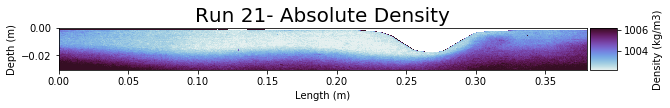

In [24]:
ims=[]

fig = plt.figure(figsize=(10,5))

for i in range(no_images):

    f_image = cv2.imread(foreground_path[i],0)
    f_image_crop=f_image[zbot_0:ztop_0,:]
    log = np.log(f_image_crop)

    #getting rid of unwated inf_values
    log[np.isinf(log)]=np.nan
    
    density = rho_bottom+np.float64(beta*(log-splintensity_bottom_ref))
    
    if what_field == 1:
        
        title = 'Run {}- Density Anomaly'.format(run_num)
        save_name = 'run_{}_anomaly'.format(run_num)
        
        cmap = cmo.cm.balance
        vmin=-2.5
        vmax=-vmin
        
        den=density[:,50:-50]-rho[:,None]
        den[den>4]=np.nan
        density_filt=signal.medfilt2d(den[50:,:],3)
        
        plt_depth=depth
    
    if what_field == 2:
        
        title = 'Run {}- Absolute Density'.format(run_num)
        save_name = 'run_{}_absolute'.format(run_num)
        
        cut=600
        plt_depth=depth/718*(718-cut)
        
        
        den=density[:,50:-50]
        den[den>rho_bottom+2]=np.nan
        density_filt=signal.medfilt2d(den[:cut,:],3)
    
        cmap = cmo.cm.dense
        vmin=rho_top
        vmax=rho_top+4
        
    plt.xlabel('Length (m)')
    plt.ylabel('Depth (m)')
    plt.title(title, fontsize=20)


    im=plt.imshow(density_filt, cmap=cmap, animated=True, vmin=vmin,vmax=vmax, extent=[0,tank_length,-plt_depth,0])
    ims.append([im])

    if i % 25 == 0:
        print('{} of {} Images Done!'.format(i,no_images))
        
ani = animation.ArtistAnimation(fig, ims, interval=125, blit=True,
                                repeat_delay=1000)


#colorbar

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label('Density (kg/m3)', rotation=90)


print('Saving!')

writer = animation.writers['ffmpeg']
ani.save('{}/densityfields/{}.mp4'.format(os.path.dirname(foreground_path[0]),save_name), dpi=400)


## Finding Velocities 
not done

In [ ]:
#using the background stratification to determine N^2
g = 9.81
rho_cor = rho[::-1]
rho_0= rho_cor[0]
d_rho = np.gradient(rho_cor,depth/rho_cor.size)
N=np.sqrt(g/rho_0*d_rho)

In [ ]:
plt.figure(figsize=(5,10))
plt.plot(rho, depth_array)

In [ ]:
depth/rho_cor.size

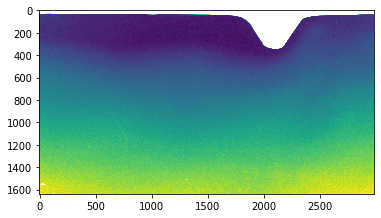

In [22]:
plt.imshow(den)

In [104]:
den

array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan, 1014.25966797,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])

In [105]:
density_filt

array([[   0.        , 1005.79140625, 1005.79140625, ..., 1005.79140625,
        1005.79140625,    0.        ],
       [1005.79140625, 1005.79140625, 1005.79140625, ..., 1005.94765625,
        1005.79140625, 1005.5765625 ],
       [1005.79140625, 1005.79140625, 1005.94765625, ..., 1005.79140625,
        1005.79140625, 1005.79140625],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan, 1014.25966797, ...,           nan,
                  nan,           nan]])